In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


TRAIN_CSV_PATH = 'training_set_pixel_size_and_HC.csv'

TRAIN_IMAGE_FOLDERS = [
    './path/to/training_images_set1',
    './path/to/training_images_set2' 
]

TEST_CSV_PATH = 'test_set_pixel_size.csv'

TEST_IMAGE_FOLDERS = [
    './path/to/test_images_set1',
    './path/to/test_images_set2'
]

BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 20
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
class HCDataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None, is_test=False):
        """
        Args:
            csv_file (string): Path to the csv file.
            img_dirs (list): List of directory paths to search for images.
            transform (callable, optional): Transform to be applied on a sample.
            is_test (bool): If True, returns dummy labels.
        """
        self.data_frame = pd.read_csv(csv_file)
        
        self.img_dirs = img_dirs if isinstance(img_dirs, list) else [img_dirs]
        self.transform = transform
        self.is_test = is_test

        self.data_frame.columns = [c.strip() for c in self.data_frame.columns]

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_name = row['filename']
        
        image = None
        for d in self.img_dirs:
            potential_path = os.path.join(d, img_name)
            if os.path.exists(potential_path):
                try:
                    image = Image.open(potential_path).convert('L')
                    break 
                except:
                    continue
        
        if image is None:

            image = Image.new('L', (224, 224))

        pixel_size = float(row['pixel size(mm)'])
        
        if self.transform:
            image = self.transform(image)

        if not self.is_test:
            label = float(row['head circumference (mm)'])
        else:
            label = 0.0

        return image, torch.tensor([pixel_size], dtype=torch.float32), torch.tensor([label], dtype=torch.float32), img_name

In [4]:
class HCRegressor(nn.Module):
    def __init__(self):
        super(HCRegressor, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        
        original_weights = self.backbone.conv1.weight.data
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.conv1.weight.data = torch.sum(original_weights, dim=1, keepdim=True)
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.regressor = nn.Sequential(
            nn.Linear(num_features + 1, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, pixel_size):
        features = self.backbone(x)
        combined = torch.cat((features, pixel_size), dim=1)
        return self.regressor(combined)

In [5]:
def train_model():
    if not os.path.exists(TRAIN_CSV_PATH):
        print(f"Error: CSV file not found at {TRAIN_CSV_PATH}")
        return None, None

    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation(15), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    full_dataset = HCDataset(
        csv_file=TRAIN_CSV_PATH, 
        img_dirs=TRAIN_IMAGE_FOLDERS, 
        transform=train_transforms
    )
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = HCRegressor().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.L1Loss()

    print(f"Starting Training on {len(full_dataset)} images...")
    
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        for images, pixel_sizes, labels, _ in train_loader:
            images, pixel_sizes, labels = images.to(DEVICE), pixel_sizes.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images, pixel_sizes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, pixel_sizes, labels, _ in val_loader:
                images, pixel_sizes, labels = images.to(DEVICE), pixel_sizes.to(DEVICE), labels.to(DEVICE)
                outputs = model(images, pixel_sizes)
                val_loss += criterion(outputs, labels).item()
        
        train_mae = running_loss/len(train_loader)
        val_mae = val_loss/len(val_loader)
        history['train_loss'].append(train_mae)
        history['val_loss'].append(val_mae)
        
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

    torch.save(model.state_dict(), 'hc_model.pth')
    print("Training Complete. Model Saved.")
    return model, history

c:\Users\Ta Quang Dung\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ta Quang Dung\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training on 999 images...
Epoch [1/20] Train MAE: 171.7657 | Val MAE: 168.7425
Epoch [2/20] Train MAE: 160.0365 | Val MAE: 150.3457
Epoch [3/20] Train MAE: 126.9800 | Val MAE: 97.7307
Epoch [4/20] Train MAE: 79.3279 | Val MAE: 63.4328
Epoch [5/20] Train MAE: 48.8930 | Val MAE: 52.6764
Epoch [6/20] Train MAE: 46.5291 | Val MAE: 52.1194
Epoch [7/20] Train MAE: 46.3851 | Val MAE: 51.9410
Epoch [8/20] Train MAE: 46.7899 | Val MAE: 52.0140
Epoch [9/20] Train MAE: 46.2496 | Val MAE: 52.3022
Epoch [10/20] Train MAE: 45.5215 | Val MAE: 51.9278
Epoch [11/20] Train MAE: 45.6035 | Val MAE: 51.9138
Epoch [12/20] Train MAE: 46.8726 | Val MAE: 52.3194
Epoch [13/20] Train MAE: 46.3051 | Val MAE: 51.9858
Epoch [14/20] Train MAE: 46.1312 | Val MAE: 51.9938
Epoch [15/20] Train MAE: 46.4135 | Val MAE: 51.9444
Epoch [16/20] Train MAE: 46.3163 | Val MAE: 51.9227
Epoch [17/20] Train MAE: 46.6662 | Val MAE: 51.9571
Epoch [18/20] Train MAE: 45.9022 | Val MAE: 51.9090
Epoch [19/20] Train MAE: 45.7489 

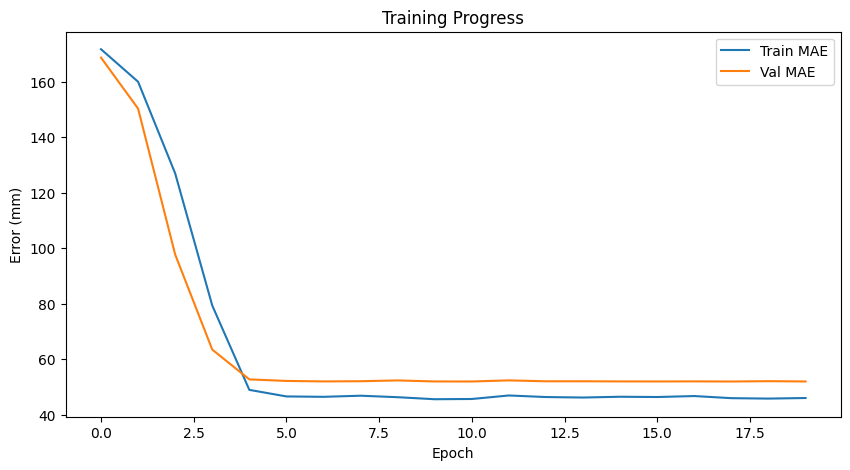

In [9]:
model, history = train_model()

if history:
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train MAE')
    plt.plot(history['val_loss'], label='Val MAE')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Error (mm)')
    plt.legend()
    plt.show()

In [11]:
def generate_submission():
    if not os.path.exists(TEST_CSV_PATH):
        print("Test CSV not found.")
        return

    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_dataset = HCDataset(
        csv_file=TEST_CSV_PATH, 
        img_dirs=TEST_IMAGE_FOLDERS, 
        transform=test_transforms,
        is_test=True
    )
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = HCRegressor().to(DEVICE)
    if os.path.exists('hc_model.pth'):
        model.load_state_dict(torch.load('hc_model.pth'))
    else:
        print("Model file not found! Train first.")
        return

    model.eval()
    results = []
    
    print("Generating predictions...")
    with torch.no_grad():
        for images, pixel_sizes, _, filenames in test_loader:
            images, pixel_sizes = images.to(DEVICE), pixel_sizes.to(DEVICE)
            outputs = model(images, pixel_sizes)
            
            for fname, pred in zip(filenames, outputs):
                results.append({'filename': fname, 'head circumference (mm)': pred.item()})
    
    df_sub = pd.DataFrame(results)
    df_sub.to_csv('submission.csv', index=False)
    print("submission.csv created successfully.")
    print(df_sub.head())

generate_submission()

c:\Users\Ta Quang Dung\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ta Quang Dung\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generating predictions...
submission.csv created successfully.
     filename  head circumference (mm)
0  000_HC.png               174.616135
1  001_HC.png               174.511322
2  002_HC.png               174.572021
3  003_HC.png               174.529251
4  004_HC.png               174.595123
